In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import datetime

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV, Lasso
from sklearn.svm import SVR
#from mlxtend.regressor import StackingRegressor
#import lightgbm as lgbm

import numpy as np
#from keras.layers import Dense, Activation
#from keras.models import Sequential


from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# Load the files
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
# Get number of observations for test and train
print([len(x) for x in [train_df, test_df]])

[1460, 1459]


In [4]:
# Combine it into one large file for data exploration and cleaning
combined_df = pd.concat([train_df, test_df])

# Explore Data

In [5]:
combined_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [6]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallCond  

# Data Cleaning

In [7]:
# Classify int variables into category if needed
combined_df["MSSubClass"] = combined_df["MSSubClass"].astype("category")
combined_df["MoSold"] = combined_df["MoSold"].astype("category")

In [8]:
# Categorical data impute with mode of neighborhood and MSSubClass or just mode of own column if missing
#impute the mode of the “Neighborhood” and “MSSubClass” when we can do so. 
# Else, we impute the column’s own mode. The logic behind this is that houses in the same neighborhood and from the same 
# class might have the same characteristics as most houses from the same class in their area.
missing_vals = ["MSZoning", "Alley", "Utilities", 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"Electrical",'KitchenQual','Functional','GarageType',"SaleType", 'GarageFinish','GarageQual','GarageCond','Exterior1st', 'Exterior2nd','FireplaceQu', "PoolQC", "Fence", "MiscFeature"]

for missing_val in missing_vals:
    try:
        combined_df[missing_val] = combined_df.groupby(['MSSubClass', "Neighborhood"], observed=False)[missing_val].transform(lambda x: x.fillna(x.mode()[0]))
   # .groupby(): groups the dataframe by unique occurences in the 'MSSubClass', "Neighborhood" column. observed=true will remove all the groups which return 0
   # .transform(): transform each unique group that was previously created using a pandas series
   # .transform(lambda x:x.do_something()) : use an anonymous function with the lambda keyword to transform each Series accordingly.
   # .mode()[0] : we grab the mode (most occuring value) of each Series, we want the first element of the mode (the most occuring) and select it with [0]. If you were to simply use x.mode() you'd have an array, not a value !
   
    except:
     combined_df[missing_val].fillna((combined_df[missing_val].mode()[0]), inplace=True)

In [9]:
# Add "Other" category as most elements are missing
combined_df["PoolQC"] = combined_df["PoolQC"].fillna("Other")

In [10]:
# Continuous data
missing_vals = ["LotFrontage", 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF1','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']
impute_vals = ["LotConfig" ,"Neighborhood",'BsmtFinType1', 'BsmtFinType2','BsmtQual', 'BsmtQual', 'BsmtQual','GarageType', 'GarageType']

for missing_val, impute_val in zip(missing_vals, impute_vals):
    combined_df[missing_val] = combined_df[missing_val].fillna(combined_df.groupby(impute_val)[missing_val].transform('mean'))

In [11]:
# Continuous impute data based on other continuous data
missing_vals = ['GarageYrBlt']
impute_vals = ['YearBuilt']

for missing_val, impute_val in zip(missing_vals, impute_vals):
    combined_df[missing_val] = combined_df[missing_val].fillna(combined_df[impute_val])

<Axes: >

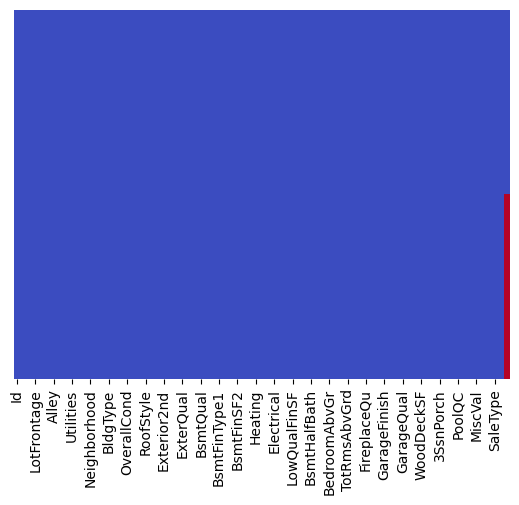

In [12]:
sns.heatmap(combined_df.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')
# only Saleprice is missing as that is what we want to predict

In [13]:
# List of cols with missing values
print([col for col in combined_df.columns if combined_df[col].isnull().any()])

['BsmtFinSF2', 'BsmtUnfSF', 'SalePrice']


In [14]:
# Fill all leftovers with mean
for missing_val in combined_df.columns.values.tolist():

    if missing_val == "SalePrice":
        pass

    else:
        try:
            combined_df[missing_val] = combined_df[missing_val].fillna(combined_df[missing_val].mean())
        except:
            pass

# List of cols with missing values
print([col for col in combined_df.columns if combined_df[col].isnull().any()])

['SalePrice']


# Feature Engineering

In [15]:
# Add and change some variables, namely the "Year" ones as it would be better to have them as "Age"
year = datetime.date.today().year
combined_df["AgeSold"] = int(year) - combined_df["YrSold"].astype(int)
combined_df["AgeGarage"] = int(year) - combined_df["GarageYrBlt"].astype(int)
combined_df["AgeBuilt"] = int(year) - combined_df["YearBuilt"].astype(int)

In [16]:
# Add some features related to total area of the house
combined_df['TotalArea'] = combined_df['TotalBsmtSF'] + combined_df['1stFlrSF'] + combined_df['2ndFlrSF'] + combined_df['GrLivArea'] +combined_df['GarageArea']
combined_df['Bathrooms'] = combined_df['FullBath'] + combined_df['HalfBath']/2
combined_df['Year average']= (combined_df['YearRemodAdd']+combined_df['YearBuilt'])/2

c:\Users\d3smo\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 92.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\d3smo\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 71.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\d3smo\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\d3smo\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 81.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(ms

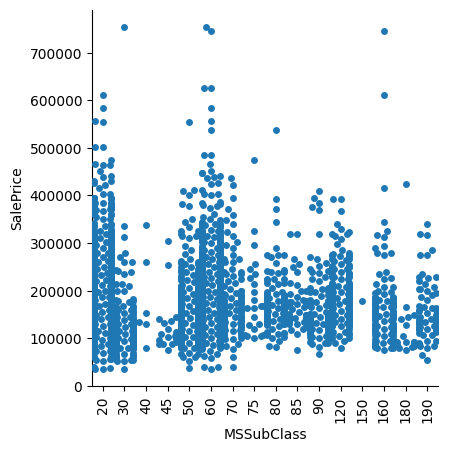

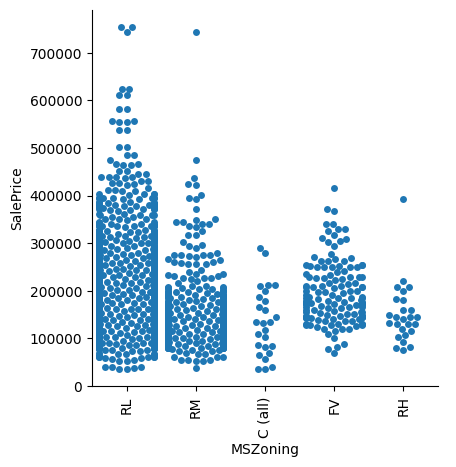

c:\Users\d3smo\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 84.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


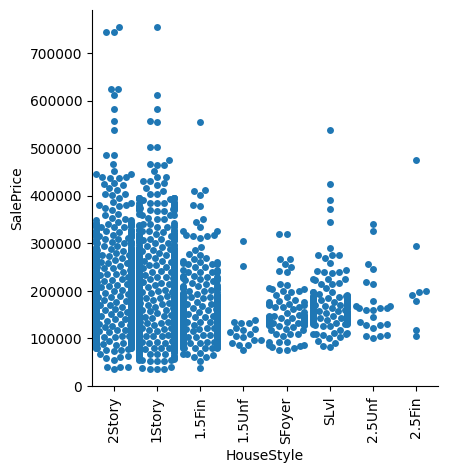

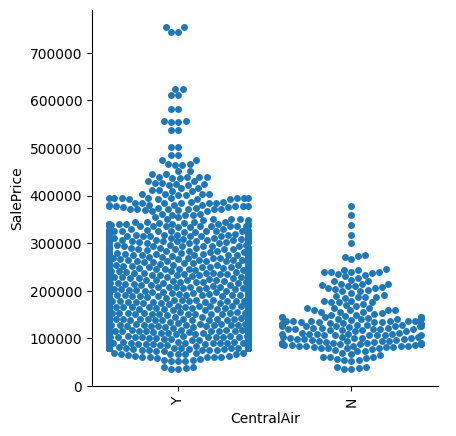

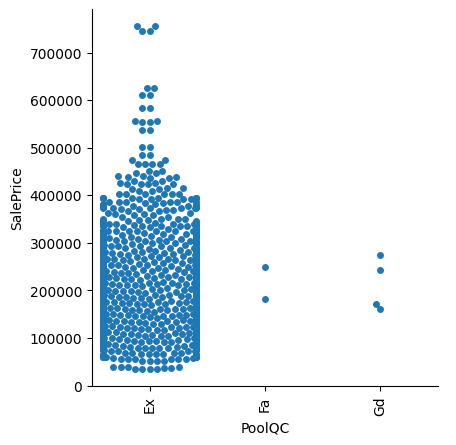

c:\Users\d3smo\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 94.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


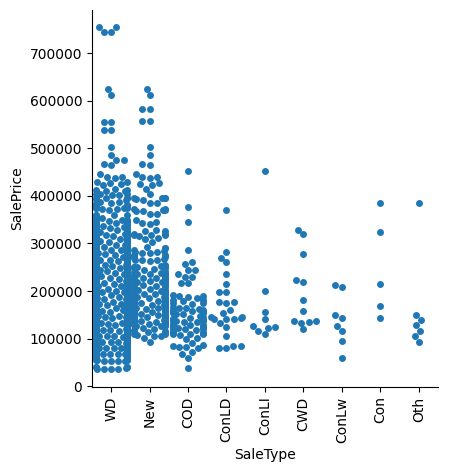

In [17]:
# Check the sale price distribution by different types of variables
for element in ["MSSubClass", "MSZoning", "HouseStyle","CentralAir", "PoolQC", "SaleType"]:
    cat_plot = sns.catplot(y="SalePrice", x= element, kind="swarm", legend="full", data=combined_df, height=4.5, aspect=3 / 3,);
    cat_plot.set_xticklabels(rotation=90)

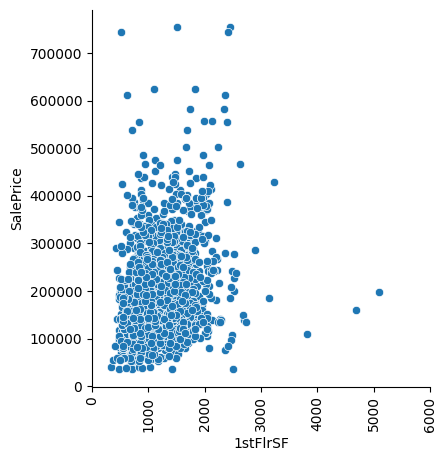

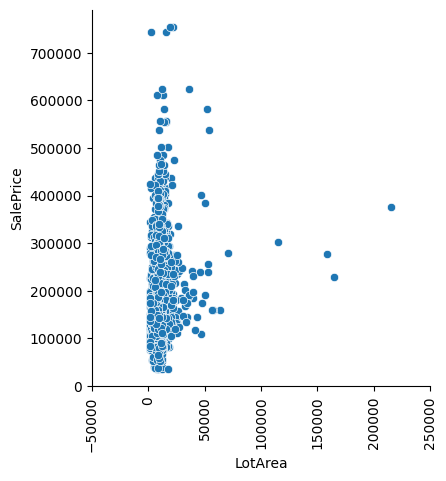

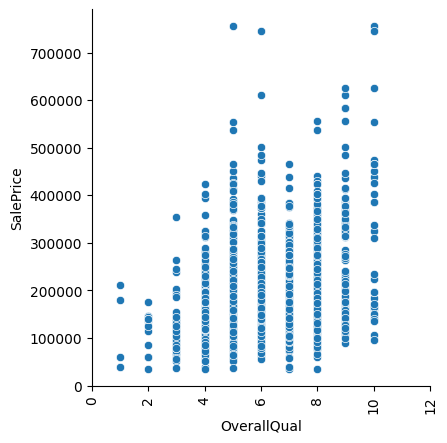

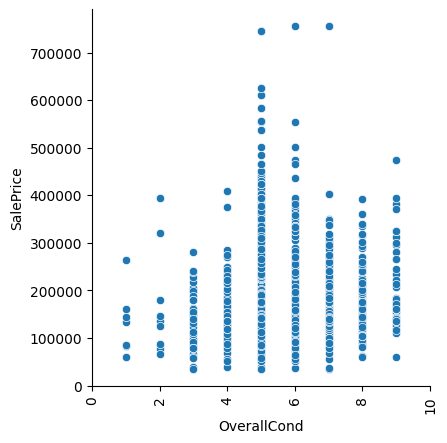

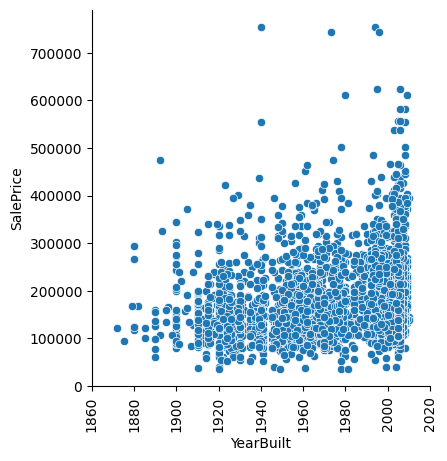

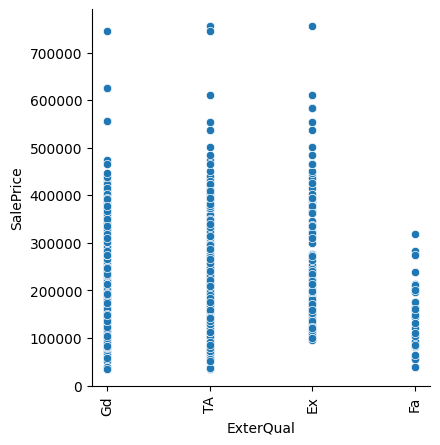

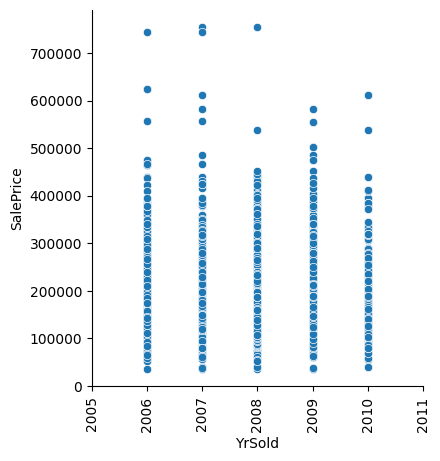

In [18]:
# Check the sale price distribution by different types of variables
for element in ["1stFlrSF", "LotArea", "OverallQual", "OverallCond", "YearBuilt","ExterQual", "YrSold"]:
    re_plot = sns.relplot(y="SalePrice", x= element, legend="full", data=combined_df, height=4.5, aspect=3 / 3,)
    re_plot.set_xticklabels(rotation=90)

In [19]:
"""
# Correlation matrix
corr_mat = combined_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_mat, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr_mat, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()
"""

'\n# Correlation matrix\ncorr_mat = combined_df.corr()\n\n# Generate a mask for the upper triangle\nmask = np.triu(np.ones_like(corr_mat, dtype=np.bool))\n\n# Generate a custom diverging colormap\ncmap = sns.diverging_palette(220, 10, as_cmap=True)\n\nsns.heatmap(corr_mat, mask=mask, cmap=cmap, center=0,\n            square=True, linewidths=.5, cbar_kws={"shrink": .5})\n\nplt.show()\n'

# Data Transformation

In [20]:
# Get dummies for our data set
combined_df = pd.get_dummies(combined_df)

In [21]:
# Split the data set so to build our model
train_df = combined_df[combined_df["SalePrice"] > 0 ]
test_df = combined_df[combined_df["SalePrice"].isna() ]
test_df = test_df.drop(["SalePrice"], axis = 1)

# Create the X and y sets
X_train_df = train_df.drop(["SalePrice"], axis = 1)
y_train_df = train_df[["Id" ,"SalePrice"]]

In [22]:
# Log transform the SalePrice as it is skewed
y_train_df["SalePrice"] = np.log1p(y_train_df["SalePrice"])

C:\Users\d3smo\AppData\Local\Temp\ipykernel_13360\2524520233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_df["SalePrice"] = np.log1p(y_train_df["SalePrice"])


In [23]:
# Set the ID col as index
for element in [X_train_df, y_train_df, test_df]:
    element.set_index('Id', inplace = True)

In [24]:
# Scale the data and use RobustScaler to minimize the effect of outliers
scaler = RobustScaler()

# Scale the X_train set
X_train_scaled = scaler.fit_transform(X_train_df.values)
X_train_df = pd.DataFrame(X_train_scaled, index = X_train_df.index, columns= X_train_df.columns)

# Scale the X_test set
X_test_scaled = scaler.transform(test_df.values)
X_test_df = pd.DataFrame(X_test_scaled, index = test_df.index, columns= test_df.columns)

# Modelling

In [25]:
# Split our training set into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_df, test_size=0.05, random_state=23)

In [28]:
# XGBOOST

# Grid search for best params
param_grid = {'max_depth':[3,4],
          'learning_rate':[0.01,0.03],
          'min_child_weight':[1,3],
          'reg_lambda':[0.1,0.5],
          'reg_alpha':[1,1.5],      
          'gamma':[0.1,0.5],
          'subsample':[0.4,0.5],
         'colsample_bytree':[0.4,0.5],
}

# Instantiate reg for gridsearch
reg = XGBRegressor()

# Conduct the gridsearch
grid_search = GridSearchCV(estimator = reg, param_grid = param_grid,
                          cv = 4, n_jobs = -1, verbose = True)

# Fit the grid search to the data
grid_search.fit(X_train_df, y_train_df)
print(grid_search.best_params_)

# Create a regressor with best parameters
xgb_reg = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3,min_child_weight=0, 
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', 
nthread=-1, scale_pos_weight=1, seed=27,reg_alpha=0.00006)

# Fit the model to the data
xgb_reg.fit(X_train, y_train)

# Predict on the test set from our training set
y_pred = xgb_reg.predict(X_test)
print("XGBoostRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

# Create predictions
predictions = np.exp(xgb_reg.predict(X_test_df))
my_pred_xgb = pd.DataFrame({'Id': X_test_df.index, 'SalePrice': predictions})

# Create CSV file
my_pred_xgb.to_csv('pred_xgb.csv', index=False)

Fitting 4 folds for each of 256 candidates, totalling 1024 fits
{'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 0.1, 'subsample': 0.5}
XGBoostRegressor RMSE: 0.14684342034178657
